In [1]:
import geopy.distance
from pyproj import Transformer
import numpy as np
import pandas as pd
from random import choices
import os
from dotenv import load_dotenv
import requests
from IPython.display import Image
import json
import polyline
from copy import deepcopy
import plotly.graph_objects as go
from ortools.constraint_solver import pywrapcp
import os
from dotenv import load_dotenv
import requests
import plotly_express as px
import chart_studio
import chart_studio.plotly as py

load_dotenv()
key = os.getenv('GCP_KEY_0X')
token = os.getenv('MAPBOX_TOKEN')
chart_studio_key = os.getenv('CHART_STUDIO')
px.set_mapbox_access_token(token)
chart_studio.tools.set_credentials_file(username='0xmarmelade', api_key=chart_studio_key)

# 1. Convert the Swiss coordinate system
From Swissgrid coordinates (LV95) we project to classic World geodesic coordinates (WGS84)

In [7]:
def LV95_to_WGS84(coordinates_df: pd.DataFrame) -> pd.DataFrame:
    transformer = Transformer.from_crs('epsg:2056', 'epsg:4326')
    return pd.DataFrame(
        np.transpose(
            transformer.transform(coordinates_df['E_KOORD'], coordinates_df['N_KOORD'])
        ),
        columns=['latitude', 'longitude']
    )
raw_statpop_dataset = pd.read_excel('STATPOP2021.xlsx')
wgs84_statpop_dataset = LV95_to_WGS84(raw_statpop_dataset).join(raw_statpop_dataset['B21BTOT']).reindex()
wgs84_statpop_dataset.to_csv('STATPOP2021_WGS84_full.csv')

In [9]:
nestle_coord = (46.466634011, 6.835639010)
wgs84_statpop_dataset = pd.read_csv('STATPOP2021_WGS84_full.csv')
distance_cutoff_km = 20

pop_density_around_nestle = wgs84_statpop_dataset[wgs84_statpop_dataset.apply(
    lambda row: geopy.distance.distance(
        (row.latitude, row.longitude), nestle_coord).km < distance_cutoff_km,
    axis=1)
].reset_index(drop=True)

pop_density_around_nestle['propability_density'] = (pop_density_around_nestle.B21BTOT / pop_density_around_nestle.B21BTOT.sum());
pop_density_around_nestle.to_csv('STATPOP2021_WGS84_nestle.csv')

# 2. Data Generation

Draw 24 employees location from the density function around Nestle's HQ

In [9]:
pop_density_around_nestle = pd.read_csv('STATPOP2021_WGS84_nestle.csv')

In [5]:
n_employees = 24
n_nodes = n_employees + 1
employee_indexes = choices(pop_density_around_nestle.index, pop_density_around_nestle.propability_density, k=n_employees)
employee_locations = pop_density_around_nestle.iloc[employee_indexes][['latitude', 'longitude']]

# We have to account for the possibility that more than one employees live at the same location
employee_locations_grouped = employee_locations.groupby([employee_locations.index, 'latitude', 'longitude'],
                                                        as_index=False).size()

In [6]:
with open('./results/2022-12-16 153833.762017.json') as result_file:
    data = json.load(result_file)
employee_locations = pd.DataFrame(
    {'latitude': list(zip(*data['employees']))[0][1:], 'longitude': list(zip(*data['employees']))[1][1:]})

In [10]:
coordinates_list = list(zip(employee_locations.latitude.tolist(), employee_locations.longitude.tolist()))
coordinates_list = [nestle_coord] + coordinates_list

In [11]:
fig = px.scatter_mapbox(employee_locations, lat='latitude', lon='longitude', mapbox_style='streets', zoom=9)
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0}, showlegend=False, autosize=True)
markers = go.Scattermapbox(
    lat=[nestle_coord[0]],
    lon=[nestle_coord[1]],
    mode='markers',
    text='Nestle Head Office',
    marker={'size': [12], 'symbol': ['suitcase'], 'opacity': [0.9], }
)
fig.add_trace(markers)
fig.show()


py.plot(fig, filename='Employee locations', auto_open=True)

'https://plotly.com/~0xmarmelade/1/'

# 2. Creating the distance matrix

In [ ]:
url = 'https://routes.googleapis.com/distanceMatrix/v2:computeRouteMatrix'
headers = {
    'Content-Type': 'application/json',
    'X-Goog-Api-Key': key,
    'X-Goog-FieldMask': 'originIndex,destinationIndex,duration,distanceMeters,status,condition'
}
payload = str({
    'origins': [{'waypoint': {
        'location': {
            'latLng': {
                'latitude': latitude,
                'longitude': longitude
            }
        }
    }} for latitude, longitude in coordinates_list],
    'destinations': [{'waypoint': {
        'location': {
            'latLng': {
                'latitude': latitude,
                'longitude': longitude
            }
        }
    }} for latitude, longitude in coordinates_list],
    'travelMode': 'DRIVE',
    'routingPreference': 'TRAFFIC_AWARE'
})
response = requests.request('POST', url, headers=headers, data=payload)

In [ ]:
distance_matrix_time = [[0] * n_nodes for _ in range(n_nodes)]
distance_matrix_distance = [[0] * n_nodes for _ in range(n_nodes)]

for distance in response.json():
    distance_matrix_time[distance['originIndex']][distance['destinationIndex']] = int(distance['duration'][:-1])
    if distance['originIndex'] == distance['destinationIndex']:
        distance_matrix_time[distance['originIndex']][distance['destinationIndex']] = 0
    else:
        distance_matrix_distance[distance['originIndex']][distance['destinationIndex']] = distance['distanceMeters']


# 4. Solving the VRP

In [ ]:
def get_solution(data, manager, routing, solution, max_capacity) -> dict():
    """Prints solution on console."""
    print(
        f'\n\n------- VRP SOLUTION {str(data["num_vehicles"])} vehicles, max capacity {str(max_capacity)} ---------- \n\n\n ')
    if not solution:
        print('No solution found !')
        return {}

    print(f'Objective: {solution.ObjectiveValue()}')
    max_route_time = 0
    solution_dict = {
        'routes': [{
            'route': [],
            'routeTotalTime': 0,
            'routeTotalDist': 0
        } for _ in range(data['num_vehicles'])],
        'objectiveTime': 0,
        'objectiveDist': 0
    }

    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = f'Route for vehicle {vehicle_id}:\n'
        route_time = 0
        route_distance = 0

        while not routing.IsEnd(index):
            plan_output += f' {manager.IndexToNode(index)} -> '
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_time += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
            route_distance += distance_matrix_distance[manager.IndexToNode(previous_index)][manager.IndexToNode(index)]

            solution_dict['routes'][vehicle_id]['route'].append(manager.IndexToNode(previous_index))

        plan_output += f'{manager.IndexToNode(index)}\n'
        plan_output += f'Time of the route: {route_time}s\n'
        solution_dict['routes'][vehicle_id]['routeTotalTime'] = route_time
        solution_dict['routes'][vehicle_id]['routeTotalDist'] = route_distance
        solution_dict['routes'][vehicle_id]['route'].append(manager.IndexToNode(index))
        solution_dict['objectiveTime'] += route_time
        solution_dict['objectiveDist'] += route_distance
        print(plan_output)
        max_route_time = max(route_time, max_route_time)
    print(f'Maximum of the route distances: {max_route_time}s')
    return solution_dict

In [ ]:
### Executes the VRP solver on the globally defined distance matrix
# Inputs:   num_vehicles: the maximum number of vehicles used
#           max_time_vehicle: each vehicle's maximum capacity (time)
# Output:   JSON containing the found solution to the VRP
# vrp_out = {'routes': [
#               {'route': [0, 4, 5, 8, 0],
#                'routeTotalTime': 5369,
#                'routeTotalDist': 3985}
#            ....],
#          'objective': 366036
#          ]},
def vrp(num_vehicles, max_time_vehicle):
    data = {
        'distance_matrix': distance_matrix_time,
        'num_vehicles': num_vehicles,
        'office': 0
    }

    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'],
                                           data['office'])

    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(origin: int, destination: int) -> int:
        return data['distance_matrix'][manager.IndexToNode(origin)][manager.IndexToNode(destination)]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        name=dimension_name,
        slack_max=0,  # no slack
        capacity=max_time_vehicle,
        fix_start_cumul_to_zero=True,
    )

    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.AUTOMATIC)
    search_parameters.time_limit.seconds = 120

    # Solve the problem
    solution = routing.SolveWithParameters(search_parameters)
    return get_solution(data, manager, routing, solution, max_time_vehicle)

# 5. Result Exploration

In [ ]:
n_shuttles_to_test = [12]
max_time_shuttle_to_test = [3800]

test_results = {
    'distance_matrix_time': distance_matrix_time,
    'distance_matrix_distance': distance_matrix_distance,
    'employees': coordinates_list,
    'results': []
}

for n_shuttle in n_shuttles_to_test:
    for max_time in max_time_shuttle_to_test:
        result = vrp(n_shuttle, max_time)
        if result != {}:
            test_results['results'].append({
                'num_vehicles': n_shuttle,
                'max_time_shuttle': max_time,
                'result': vrp(n_shuttle, max_time),
            })
        print(f'solution found!')

In [ ]:
from datetime import datetime

with open(f"./results/{str(datetime.now()).replace(':', '')}.json", 'w') as result_file:
    result_file.write(json.dumps(test_results))

# 6. Route Visualisation

In [20]:
test_results = 0
with open(f"./results/2022-12-16 163709.548510.json", 'r') as result_file:
    test_results = json.load(result_file)

In [26]:
test_results['results'][2]

{'num_vehicles': 5,
 'max_time_shuttle': 6000,
 'result': {'routes': [{'route': [0, 9, 21, 4, 2, 1, 0],
    'routeTotalTime': 4621,
    'routeTotalDist': 55919},
   {'route': [0, 11, 17, 12, 16, 22, 0],
    'routeTotalTime': 3795,
    'routeTotalDist': 49224},
   {'route': [0, 20, 14, 8, 3, 19, 0],
    'routeTotalTime': 4770,
    'routeTotalDist': 61399},
   {'route': [0, 23, 15, 18, 6, 0],
    'routeTotalTime': 4816,
    'routeTotalDist': 61157},
   {'route': [0, 13, 5, 24, 7, 10, 0],
    'routeTotalTime': 3694,
    'routeTotalDist': 46595}],
  'objectiveTime': 21696,
  'objectiveDist': 274294}}

In [32]:
test_run_to_draw = 2

shuttle_routes = \
    [[
        f'{str(coordinates_list[current_index][0])},' \
        f'{str(coordinates_list[current_index][1])}'
        for current_index in route['route']]
        for route in test_results['results'][test_run_to_draw]['result']['routes']]

In [33]:
### Function to give a list of directions to follow to go from origin to destination
# Inputs:   origin: a string with the localisation point of the origin
#           destination: a string with the localisation point of the destination
# Output:   A list of tuple (locations) representing the path from origin to destination
colors = ["blue", "red", "green", "orange", "black", "brown", 'gray', "white", '0xE5F5FE', 'purple', 'black']


def get_directions(origin, destination):
    url = f'https://maps.googleapis.com/maps/api/directions/json' \
          f'?origin={origin}' \
          f'&destination={destination}' \
          f'&key={key}' \
          f'&size=1280x1280'

    response = requests.request("GET", url)
    travel_route_poly = response.json()['routes'][0]['overview_polyline']['points']
    direction_dict = response.json()

    lat = direction_dict["routes"][0]["legs"][0]["start_location"]["lat"]
    long = direction_dict["routes"][0]["legs"][0]["start_location"]["lng"]
    travel_list = [str(f'{lat},{long}')]

    for l in direction_dict["routes"][0]["legs"][0]["steps"]:
        lat = l["end_location"]["lat"]
        long = l["end_location"]["lng"]
        tmp = f'{str(lat)[:-1]},{str(long)[:-1]}'
        travel_list.append(str(tmp))

    travel_list = "|".join(travel_list)

    return  travel_list, polyline.decode(travel_route_poly)

In [34]:
### Funtion to create the path between all localisation points of a list
# Inputs:   list: a list of strings with location points
# Outputs:  a string with the path to follow
def fct_give_parcours(list, color):
    path_poly = []
    path_str = []
    start = list.pop(0)
    while list:
        tmp_str, tmp_poly = get_directions(start, list[0])
        path_str.append(tmp_str)
        path_poly += tmp_poly
        start = list.pop(0)

    parcours = "|".join(path_str)
    travel_list = f'&path=color:{color}|weight:5|{parcours}'

    return (travel_list, path_poly)

In [35]:
### Function to create a map with the localisations and path to follow
# Inputs:   shuttles: a list of lists with strings of loaclisation points to visit
#           paths: a string with the path to follow
# Output:   A map with the localisations to visit (numbered from 0 (start)), and the path in a random color

def fct_maps(shuttles, paths):
    # Start with Nestle HQ Marker
    labels_list = "&markers=color:" + "0xCE0635" + "%7Clabel:" + str('N') + "%7C" + str(shuttle_routes[0][0])
    c = 0
    for shuttle in shuttles:
        labels_s = ""
        # We only start labelling from 1st stop to keep the 0 special.
        for i in range(len(shuttle))[1:]:
            labels_s = labels_s + "&markers=size:mid%7Ccolor:" + colors[c] + "%7Clabel:" + str(i) + "%7C" + str(shuttle[i])
        labels_list = labels_list + labels_s
        c += 1

    url = f'https://maps.googleapis.com/maps/api/staticmap' \
          f'?size=1400x800' \
          f'&zoom=11' \
          f'{labels_list}' \
          f'{paths}' \
          f'&key={key}'
    print(str(len(url)))
    response = requests.request("GET", url)
    print(response.status_code)
    return Image(response.content)

In [36]:
### Function to run the whole algorithm
# Inputs:   shuttles: a list of lists with strings of loaclisation points to visit
#           key: the maps api key
# Output:   A map with the localisations to visit (numbered from 0 (start)), and the path in a random color
def fct_run_maps(shuttles):
    global all_paths_coords
    paths = ""
    c = 0

    for s in deepcopy(shuttles):
        path_str, path_coords = fct_give_parcours(s, colors[c])
        to_append = pd.DataFrame(data={'lat': list(zip(*path_coords))[0], 'long': list(zip(*path_coords))[1],
                                       'shuttle_route': [c] * len(path_coords)})
        all_paths_coords = pd.concat([all_paths_coords, to_append], ignore_index=True)
        paths = paths + path_str
        c += 1

    return (fct_maps(shuttles, paths))

11803
200


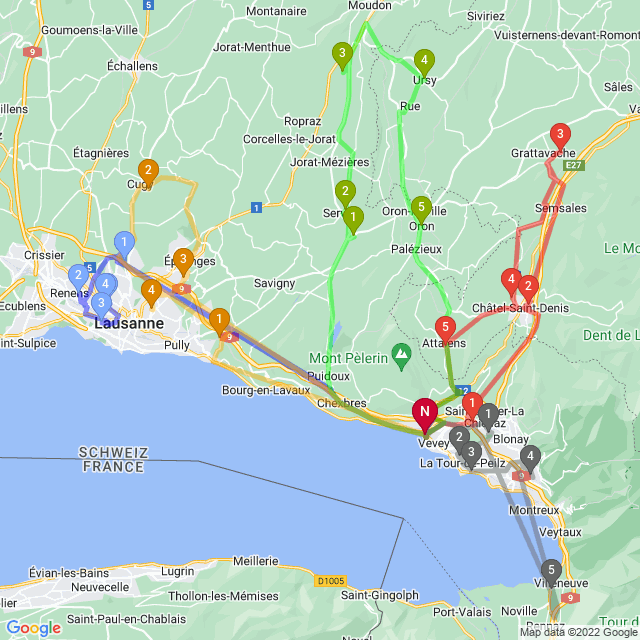

In [37]:
all_paths_coords = pd.DataFrame(columns=['lat', 'long', 'shuttle_route'])
fct_run_maps(deepcopy(shuttle_routes))

In [38]:
all_markers = [(position, i) for i, route in enumerate(shuttle_routes) for position in route[1:-1]]
all_markers_df = pd.DataFrame(list(zip(*all_markers))[0])[0].str.split(',', expand=True)
all_markers_df['shuttle_route'] = list(zip(*all_markers))[1]
all_markers_df.rename(columns={0: 'lat', 1: 'long'}, inplace=True)
all_markers_df.lat = all_markers_df.lat.astype(float)
all_markers_df.long = all_markers_df.long.astype(float)

# We add the nestle HQ to the list, once
all_markers_df = pd.concat([all_markers_df, pd.DataFrame([[nestle_coord[0], nestle_coord[1], len(shuttle_routes) + 1]],
                                                         columns=['lat', 'long', 'shuttle_route'])], ignore_index=True)

In [39]:
fig = px.line_mapbox(all_paths_coords, 'lat', 'long', color='shuttle_route', mapbox_style='streets', zoom=9)
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0}, showlegend=False, autosize=True)
n_shuttles = all_markers_df.shuttle_route.max()
markers = go.Scattermapbox(
    lat=all_markers_df.lat.tolist(),
    lon=all_markers_df.long.tolist(),
    mode='markers',
    opacity=0.9,
    marker={'size': ([15] * len(all_markers_df)) + [15], 'symbol': (['marker'] * len(all_markers_df)) + ['suitcase']}
)
fig.add_trace(markers)
fig.show()
py.plot(fig, filename='Shuttle route example', auto_open=True)

'https://plotly.com/~0xmarmelade/12/'

# 7. Analysis

In [5]:
data = {}
with open('./results/2022-12-16 163709.548510.json') as result_file:
    data = json.load(result_file)

"""
data {
    'distance_matrix_time': distance_matrix_time,
    'employees': coordinates_list,
    'results': [
         'num_vehicles': n_shuttle,
         'max_time_shuttle': max_time,
         'result': {
            'routes': [{
                'route': [],
                'routeTotalTime': 0,
                'routeTotalDist': 0
                },
                ... more routes
            ]
        'objectiveTime': 0,
        'objectiveDist': 0
            },
        ... more results
        ]
    ]
}
""";

In [83]:
from csv import writer
### Dist & Emissions avoided
# Inputs :  dist_matrix: the distance matrix
#           vrp_out: the results of the vrp
# Outputs:  - the avoided distance in meters
#           - the avoided emissions in gCO2eq

def fct_avoided_dist(dist_matrix, vrp_out):
    EMISSION_CAR     = 0.118 #[kg/(m)]
    EMISSION_SHUTTLE = 0.186 #[kg/(m*passanger)]

    FIRST_EMPLOYEE = 1
    COMPANY_COLUMN = 0

    avoided_dist = 0
    em_shuttles  = 0
    em_cars      = 0
    nb_employees = len(dist_matrix)

    for s in range(len(vrp_out['routes'])):

        dist_cars = 0
        for i in range(FIRST_EMPLOYEE, len(vrp_out['routes'][s]['route'])-1):
            dist_cars += dist_matrix[i][COMPANY_COLUMN]

        avoided_dist += (dist_cars - vrp_out['routes'][s]['routeTotalDist'])
        em_shuttles  += (vrp_out['routes'][s]['routeTotalDist'] * EMISSION_SHUTTLE)
        em_cars      += (dist_cars * EMISSION_CAR)

    avoided_em = (em_cars - em_shuttles)

    return(avoided_dist, avoided_em)

In [90]:
dist_cars = 0
for employee_distance in data['distance_matrix_distance']:
    dist_cars += employee_distance[0]
dist_cars

404661

In [84]:
### Overall time of work loss
# Inputs :  time_matrix: the time matrix between all employees
#           vrp_time: the time result of the vrp
# Outputs:  - the overall time lost in seconds
#           - mean time lost
#           - the maximum time lost for all employees
#           - the minimum time lost for all employees

def fct_time_lost(time_matrix, vrp_out):
    FIRST_SHUTTLE  = 0
    FIRST_EMPLOYEE = 1
    COMPANY_COLUMN = 0

    tot_time_lost = 0
    max_time_lost = 0
    min_time_lost = vrp_out['routes'][FIRST_SHUTTLE]['routeTotalTime'] - time_matrix[vrp_out['routes'][FIRST_SHUTTLE]['route'][FIRST_EMPLOYEE]][COMPANY_COLUMN]
    nb_employees  = len(time_matrix)

    for s in range(len(vrp_out['routes'])):
        for i in range(FIRST_EMPLOYEE, len(vrp_out['routes'][s]['route'])-1):
            time_lost_i = (vrp_out['routes'][s]['routeTotalTime'] - time_matrix[i][COMPANY_COLUMN])
            tot_time_lost  += time_lost_i

            if time_lost_i > max_time_lost:
                max_time_lost = time_lost_i

            if time_lost_i < min_time_lost:
                min_time_lost = time_lost_i

    mean_time_lost = tot_time_lost/nb_employees

    return(tot_time_lost, mean_time_lost, max_time_lost, min_time_lost)

In [85]:
### Calculate & save results
# Inputs:   create_file: a boolean : true to create a new file (and erase previous one), False to add a row to the existing file
#           test_number: the name of the test, it will appear on the first column of the output
#           dist_matrix: the distance matrix
#           time_matrix: the time matrix
#           vrp_out: the output dictionary of the vrp
# Output:   - a print of the costs
#           - a file called "outputs-csv" with the costs
def fct_print_costs_save(create_file, test_number, dist_matrix, time_matrix, vrp_out):
    if create_file == True:
        with open('./results/metrics-outputs.csv', 'w', newline='') as file:
            # 2. step
            w = writer(file)
            # 3. step
            w.writerow(["Test number; total dist[m]; total time[s]; avoided dist [m]; avoided emissions [gCO2eq]; total time lost [s]; mean time lost [s]; max_time_lost [s]; min_time_lost[s]"])


    [avoided_dist, avoided_em] = fct_avoided_dist(dist_matrix, vrp_out)
    [tot_time_lost, mean_time_lost, max_time_lost, min_time_lost] = fct_time_lost(time_matrix, vrp_out)
    newrow = [str(test_number)+ ";" + str(vrp_out["objectiveDist"]) + ";" + str(vrp_out["objectiveTime"]) + ";" + str(avoided_dist)+";"+str(avoided_em)+";"+str(tot_time_lost)+";"+str(mean_time_lost)+";"+str(max_time_lost)+";"+str(min_time_lost)]

    with open(f'./results/metrics-outputs.csv', 'a+', newline='') as write_obj:
        # Create a writer object from csv module
        csv_writer = writer(write_obj)
        # Add contents of list as last row in the csv file
        csv_writer.writerow(newrow)

    print(
        "Total distance ---------- " + str(vrp_out["objectiveDist"]) + " [m]\n"
        "Total time -------------- " + str(vrp_out["objectiveTime"]) + " [s]\n"
        "avoided distance -------- " + str(avoided_dist) + " [m]\n"
        "avoided emissions ------- " + str(avoided_em) + " [kgCO2eq]\n"
        "total time lost --------- " + str(tot_time_lost) + " [s]\n"
        "mean time lost ---------- " + str(mean_time_lost) + " [s]\n"
        "maximum time lost ------- " + str(max_time_lost) + " [s]\n"
        "minimum time lost ------- " + str(min_time_lost) + " [s]\n"
    )

In [86]:
def export_result(dfjson):
    title=' '.join(
        ["Test 1:", str(dfjson['results'][0]['num_vehicles']), "shuttles,", str(dfjson['results'][0]['max_time_shuttle']), "max."]
    )

    fct_print_costs_save(
        True, title,
        dfjson['distance_matrix_distance'],
        dfjson['distance_matrix_time'],
        dfjson['results'][0]['result']
    )

    for i in range(1,len(data['results'])):
        title=' '.join(
            ["Test:",str(i+1), str(dfjson['results'][i]['num_vehicles']), "shuttles,", str(dfjson['results'][i]['max_time_shuttle']), "max."]
        )

        fct_print_costs_save(i==0, title,
                             dfjson['distance_matrix_distance'],
                             dfjson['distance_matrix_time'],
                             dfjson['results'][i]['result']
                             )

In [87]:
export_result(data)

Total distance ---------- 283699 [m]
Total time -------------- 21534 [s]
avoided distance -------- 120962 [m]
avoided emissions ------- -5018.016000000003 [kgCO2eq]
total time lost --------- 93337 [s]
mean time lost ---------- 3733.48 [s]
maximum time lost ------- 4817 [s]
minimum time lost ------- 3229 [s]

Total distance ---------- 284445 [m]
Total time -------------- 21324 [s]
avoided distance -------- 120216 [m]
avoided emissions ------- -5156.771999999997 [kgCO2eq]
total time lost --------- 91169 [s]
mean time lost ---------- 3646.76 [s]
maximum time lost ------- 4845 [s]
minimum time lost ------- 2908 [s]

Total distance ---------- 274294 [m]
Total time -------------- 21696 [s]
avoided distance -------- 130367 [m]
avoided emissions ------- -3268.6860000000015 [kgCO2eq]
total time lost --------- 66111 [s]
mean time lost ---------- 2644.44 [s]
maximum time lost ------- 4183 [s]
minimum time lost ------- 1566 [s]

Total distance ---------- 302183 [m]
Total time -------------- 23045 

In [73]:
data['distance_matrix_distance']

[[0,
  24311,
  24793,
  26775,
  35065,
  2537,
  20323,
  8706,
  24676,
  21275,
  17519,
  3313,
  23036,
  4923,
  16400,
  25536,
  13982,
  13026,
  19673,
  17406,
  15044,
  24701,
  9999,
  14241,
  3991],
 [24001,
  0,
  1512,
  30985,
  1902,
  28762,
  3932,
  31241,
  24000,
  4117,
  40054,
  27020,
  44323,
  28065,
  19886,
  8377,
  35269,
  34313,
  8487,
  25231,
  20844,
  2355,
  29359,
  12702,
  31621],
 [24073,
  507,
  0,
  31056,
  1973,
  28834,
  4004,
  31313,
  24071,
  4188,
  40126,
  27091,
  44394,
  28137,
  19957,
  8449,
  35340,
  34385,
  8558,
  25302,
  20916,
  2427,
  29431,
  12773,
  31692],
 [26645,
  31109,
  31591,
  0,
  29905,
  32062,
  27023,
  34542,
  8740,
  28073,
  43354,
  30320,
  12478,
  31365,
  10273,
  27985,
  17084,
  19409,
  24280,
  9409,
  11718,
  31499,
  16840,
  21846,
  34921],
 [20028,
  2156,
  2200,
  29762,
  0,
  38764,
  3726,
  41243,
  22777,
  4771,
  50056,
  37022,
  29534,
  38067,
  17848,
  9567,
